In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Picture Augmentation by Compose function
# examples: https://pytorch.org/docs/stable/torchvision/transforms.html
transformer_train = torchvision.transforms.Compose([
    # torchvision.transforms.ColorJitter(
    #    brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
    transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomAffine(0, translate=(0.1,0.1)),
    # torchvision.transforms.RandomPerspective(),
    transforms.ToTensor()
])

# train dataset for augmented data training
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, transform=transformer_train, download=True)

# test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='.', train=False, transform=transforms.ToTensor(), download=True)

test_dataset.data.shape 

Files already downloaded and verified
Files already downloaded and verified


(10000, 32, 32, 3)

In [3]:
# behaves differently from MNIST / Fashion MNIST
# it is a Numpy array!
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [4]:
# We are working with color images
train_dataset.data.shape

(50000, 32, 32, 3)

In [5]:
# number of classes
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


In [6]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
# Train dataset to Tensor after download
train_dataset_fixed = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
train_loader_fixed = torch.utils.data.DataLoader(
    dataset=train_dataset_fixed,
    batch_size=batch_size,
    shuffle=False)

Files already downloaded and verified


In [8]:
# Make one for testing
#the data transformer mapped the data to(0,1)
# and also moved the color channel before height/width
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset_fixed,
                                        batch_size=1,
                                        shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(x.shape)
    print(y.shape)
    break

tensor([[[[0.1098, 0.1020, 0.1490,  ..., 0.0863, 0.0784, 0.0824],
          [0.1529, 0.1216, 0.1412,  ..., 0.1294, 0.0941, 0.0784],
          [0.1569, 0.1529, 0.1451,  ..., 0.1098, 0.0863, 0.0941],
          ...,
          [0.7647, 0.7490, 0.7843,  ..., 0.1490, 0.1569, 0.1529],
          [0.6980, 0.6667, 0.6902,  ..., 0.1333, 0.1373, 0.1412],
          [0.5922, 0.5882, 0.6196,  ..., 0.1176, 0.1333, 0.1451]],

         [[0.1098, 0.1059, 0.1569,  ..., 0.0510, 0.0431, 0.0471],
          [0.1529, 0.1255, 0.1490,  ..., 0.0941, 0.0588, 0.0431],
          [0.1569, 0.1569, 0.1529,  ..., 0.0745, 0.0510, 0.0588],
          ...,
          [0.6314, 0.6196, 0.6549,  ..., 0.0745, 0.0824, 0.0784],
          [0.5725, 0.5412, 0.5647,  ..., 0.0667, 0.0745, 0.0745],
          [0.4667, 0.4667, 0.4941,  ..., 0.0588, 0.0745, 0.0863]],

         [[0.0588, 0.0392, 0.0706,  ..., 0.0627, 0.0549, 0.0588],
          [0.1020, 0.0588, 0.0627,  ..., 0.1059, 0.0706, 0.0549],
          [0.1059, 0.0902, 0.0667,  ..., 0

In [9]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)      # maxpool2d(2) : 1/2 size shrink
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)      
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)      
        )
        
        # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
        # H_out = H_in + 2p - 2 --> p = 1 if H_out = H_in  --> padding = 1 makes the same size image between input and output
        
        # Easy to calculate output
        # 32 > 16 > 8 > 4
        
        # define the linear layers
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, K)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x

In [10]:
# Instantiate the model
model = CNN(K)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
    
        # Get train loss and test loss
        train_loss = np.mean(train_loss)   # a little misleading

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=80)

Epoch 1/80, Train Loss: 1.4371, Test Loss: 1.1105, Duration: 0:00:31.521887
Epoch 2/80, Train Loss: 1.0261, Test Loss: 0.9016, Duration: 0:00:22.717646
Epoch 3/80, Train Loss: 0.8587, Test Loss: 0.7930, Duration: 0:00:22.584353
Epoch 4/80, Train Loss: 0.7641, Test Loss: 0.7301, Duration: 0:00:22.627538
Epoch 5/80, Train Loss: 0.6936, Test Loss: 0.6994, Duration: 0:00:22.532865
Epoch 6/80, Train Loss: 0.6428, Test Loss: 0.6434, Duration: 0:00:22.469097
Epoch 7/80, Train Loss: 0.6096, Test Loss: 0.6104, Duration: 0:00:22.484931
Epoch 8/80, Train Loss: 0.5754, Test Loss: 0.6004, Duration: 0:00:22.494580
Epoch 9/80, Train Loss: 0.5592, Test Loss: 0.6051, Duration: 0:00:22.476819
Epoch 10/80, Train Loss: 0.5283, Test Loss: 0.5725, Duration: 0:00:22.496389
Epoch 11/80, Train Loss: 0.5126, Test Loss: 0.5527, Duration: 0:00:22.488195
Epoch 12/80, Train Loss: 0.4890, Test Loss: 0.5365, Duration: 0:00:22.497531
Epoch 13/80, Train Loss: 0.4792, Test Loss: 0.5511, Duration: 0:00:22.495140
Epoch 14

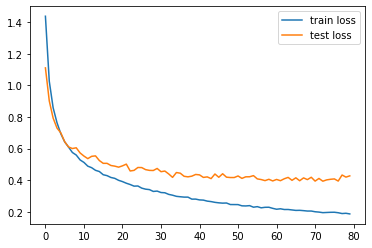

In [15]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [16]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    # print(_, predictions)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9377, Test acc: 0.8778


In [17]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = dm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    # color 부여
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[869   9  19  13  10   1   2  10  45  22]
 [  5 927   1   3   0   1   0   3   9  51]
 [ 33   1 793  36  55  18  37  19   3   5]
 [  8   0  26 787  31  74  34  20   7  13]
 [  9   1  17  26 893  12  13  28   0   1]
 [  7   0  20 146  26 762   8  26   1   4]
 [  6   1  14  25  17   6 927   2   2   0]
 [  8   1   5  29  23  12   4 911   3   4]
 [ 18  12   4   5   0   0   0   3 946  12]
 [  8  25   1   3   2   2   0   7  12 940]]


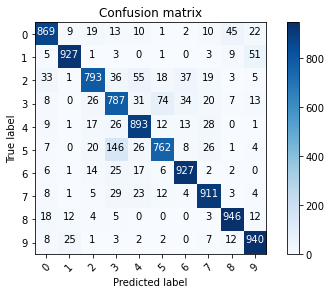

In [18]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])                   # p_test : prediction test

for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)  
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))   # concatenate : 여러개의 array를 붙임
    #print(p_test)
    #p_test2 = np.array(predictions.cpu().numpy())    
    # p_test2와 같이 array를 바로 감쌀수도 있으나, 그러면 concatenate 처럼 For loop 동안에 발생한 모든 array를 붙일 수 없음
    #print(p_test2)
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [19]:
# Label mapping
labels = '''airplane = 0
automobile = 1
bird = 2
cat = 3
deer = 4
dog = 5
frog = 6
horse = 7
ship =8
truck = 9'''.split("\n")

In [20]:
labels

['airplane = 0',
 'automobile = 1',
 'bird = 2',
 'cat = 3',
 'deer = 4',
 'dog = 5',
 'frog = 6',
 'horse = 7',
 'ship =8',
 'truck = 9']

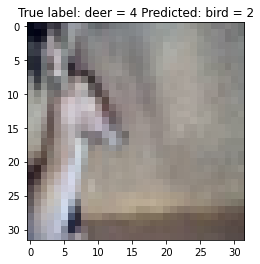

In [27]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title('True label: %s Predicted: %s' % (labels[y_test[i]], labels[int(p_test[i])]));

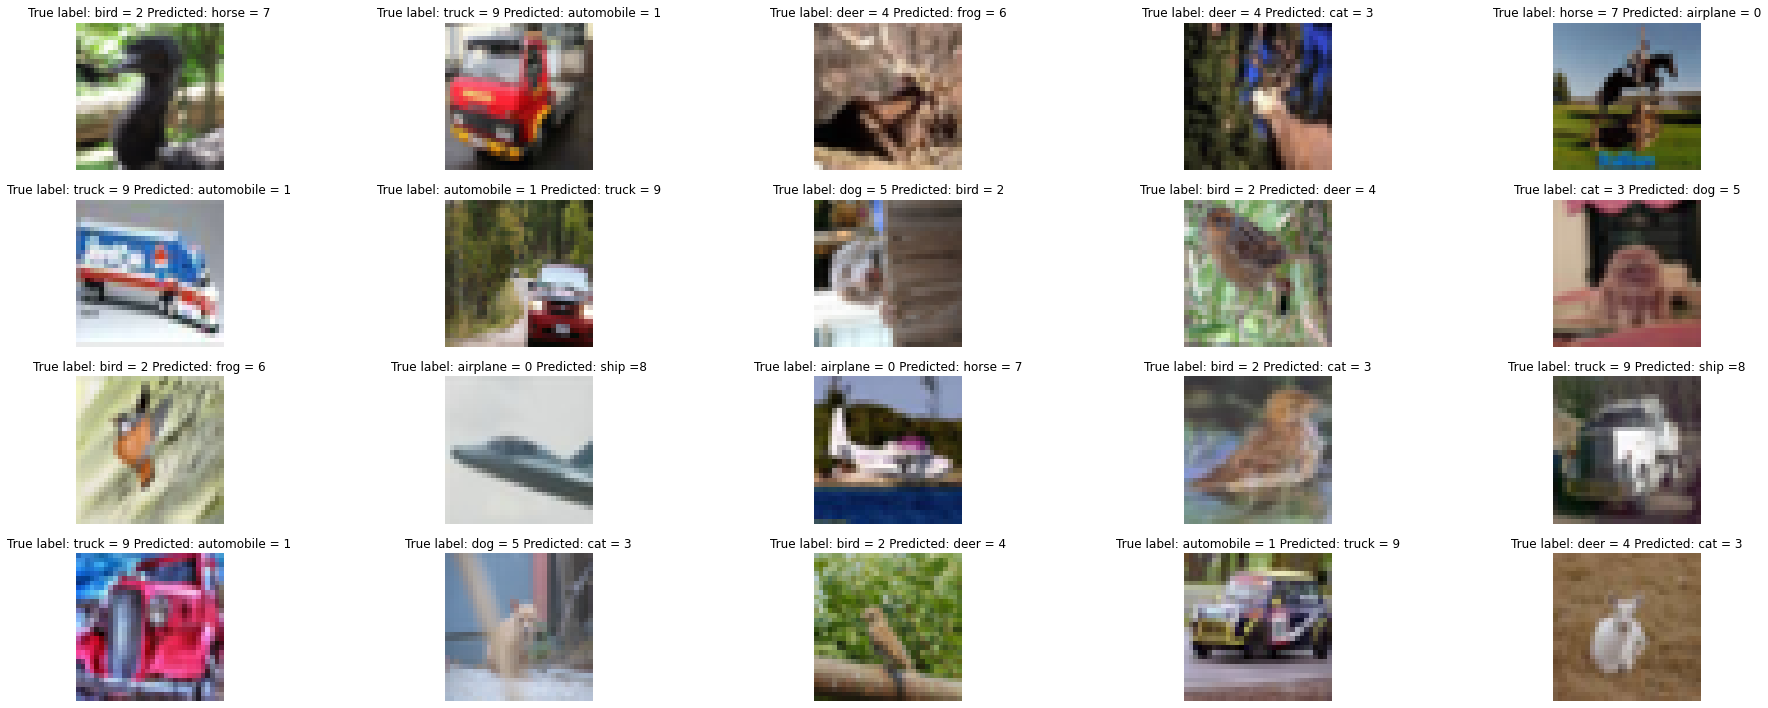

In [30]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 20, replace=False)
plt.figure(figsize=(32,32))

for j, i in enumerate(sample_idx):
    plt.subplot(10,5,j+1)
    plt.axis('off')
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.title('True label: %s Predicted: %s' % (labels[y_test[i]], labels[int(p_test[i])]));

In [24]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6